In [84]:
import numpy as np
from tqdm.notebook import tqdm
import trimesh
from queue import PriorityQueue
import matplotlib.pyplot as plt
from make_vtk import write_lines_to_vtk
from vtk_revise import read_vtk,write_vtk
# import cupy as cp

In [85]:
white = read_vtk('./AllCortexData/GS_CortexODE/SUBJ_001_MR_BL/surf/lh.CortexODE.white.vtk')
pial = read_vtk('./AllCortexData/GS_CortexODE/SUBJ_001_MR_BL/surf/lh.CortexODE.pial.vtk')



white_vertices = white['vertices']
white_faces = white['faces'][:,1:]

pial_vertices = pial['vertices']
pial_faces = pial['faces'][:,1:]



In [86]:
import trimesh
import numpy as np

# white 2 pial directions
white2pial_dir = pial_vertices - white_vertices


# Create the meshes
origin_mesh = trimesh.Trimesh(vertices=white_vertices, faces=white_faces)
target_mesh = trimesh.Trimesh(vertices=pial_vertices, faces=pial_faces)

# Create intersectors for both meshes
origin_intersector = trimesh.ray.ray_pyembree.RayMeshIntersector(origin_mesh)
target_intersector = trimesh.ray.ray_pyembree.RayMeshIntersector(target_mesh)

# For each vertex in the origin mesh, shoot a ray in the direction of its normal
origins = origin_mesh.vertices
directions = origin_mesh.vertex_normals.copy()

dir_sign = (np.sum(white2pial_dir*directions,axis=1) < 0)
directions[dir_sign] *= -1

 
# Get self - intersections   # trimesh는 스스로 겹치는 것은 취급을 안한다. 
self_locations, self_index_ray, self_index_tri = origin_intersector.intersects_location(
    origins,
    directions, 
    multiple_hits=True)

# Get intersections
locations, index_ray, index_tri = target_intersector.intersects_location(
    origins,
    directions, 
    multiple_hits=True)


# print(locations.shape)   #(530738, 3)
# print(index_ray.shape)   #(530738,)

In [87]:
thickness = []
pair = []

self_intersect_idx = []
not_intersect_idx = []

too_long = []
too_long_pair = []



self_intersect_pos = self_locations                   # ( 530738 , 3 ) 
self_origin_pos = origins[self_index_ray]             # ( 530738 , 3 ) 
self_directions_vector = directions[self_index_ray]   # ( 530738 , 3 ) 

self_distances = np.sqrt(np.sum((self_intersect_pos - self_origin_pos)**2,axis=1)) 


intersect_pos = locations                    # ( 530738 , 3 ) 
origin_pos = origins[index_ray]              # ( 530738 , 3 ) 
directions_vector = directions[index_ray]    # ( 530738 , 3 ) 

threshold = 7

distances = np.sqrt(np.sum((intersect_pos - origin_pos)**2,axis=1))   # ( 530738 ,  ) 




for i in tqdm(range(len(origins))):
  

  if i in index_ray :     # white에서 pial intersect 있을 때 
    white2pial_d = white2pial_dir[i]
    
    idx = np.where(index_ray == i)[0]                           # 530738개 중에 i를 가지는 index 
    temp_dist = distances[idx]                                  # i로 이루어진 거리들
    temp_direction_vetors = directions_vector[idx]              # i로 이루어진 방향들
    real_sign = np.dot(temp_direction_vetors,white2pial_d) > 0  # 기존의 방향과 우리가 구한 방향이 같은 방향이라면 양수 아니면 음수 ( 기존 방향 : white 2 pial )
    positive_count = np.sum(real_sign)                          # 맞는 방향으로 intersect하는 친구들의 갯수 
    
    
    if positive_count == 0:                                     # 만일 맞는 방향으로 intersect하는 친구가 없다면 continue
      thickness.append(float('nan'))
      not_intersect_idx.append(i)
      continue 
   
    else :                                                      # 맞는 방향으로 통과한다면, 그중 가장 작은 친구 선택.
      smallest_index = np.nonzero(real_sign)[0][np.argmin(temp_dist[real_sign])]
      smallest_dist = temp_dist[smallest_index]
      real_idx = idx[smallest_index]
      

      if i in self_index_ray:                                                    # self intersect 할때
        
        self_idx = np.where(self_index_ray == i)[0]
        self_temp_dist = self_distances[self_idx]
        temp_self_direction_vetors = self_directions_vector[self_idx]
        self_sign_mask = np.dot(temp_self_direction_vetors,white2pial_d) > 0     # self intersect 하는 친구가 맞는 방향이라면
        
        self_positive_count = np.sum(self_sign_mask)     # self intersect하는 친구들 갯수
        
        if self_positive_count == 0 :        # 방향이 맞지 않아 self intersect하는 친구들이 없다면 thickness 저장.
          
          if smallest_dist > threshold: 
            thickness.append(float('nan'))
            too_long.append(i)
            too_long_pair.append((origin_pos[real_idx],intersect_pos[real_idx]))
            
          else : 
            thickness.append(smallest_dist)
            pair.append((origin_pos[real_idx],intersect_pos[real_idx]))
        
        else : # self intersect하는 친구들이 있다면 
          self_mask_index = np.nonzero(self_sign_mask)[0][np.argmin(self_temp_dist[self_sign_mask])]
          self_smallest_dist= self_temp_dist[self_mask_index]
          

          if self_smallest_dist < smallest_dist : 
            thickness.append(float('nan'))
            self_intersect_idx.append(i)

      
          elif smallest_dist > threshold: 
            thickness.append(float('nan'))
            too_long.append(i)
            too_long_pair.append((origin_pos[real_idx],intersect_pos[real_idx]))

          else : 
            thickness.append(smallest_dist)
            pair.append((origin_pos[real_idx],intersect_pos[real_idx]))

      
      else : # 애초에 self intersect 하는 친구가 없다면,
        
        if smallest_dist > threshold: 
          thickness.append(float('nan'))
          too_long.append(i)
          too_long_pair.append((origin_pos[real_idx],intersect_pos[real_idx]))
        else : 
          thickness.append(smallest_dist)
          pair.append((origin_pos[real_idx],intersect_pos[real_idx]))
        
  else : # 아무것도 intersect하지 않을 경우.
    thickness.append(float('nan'))
    not_intersect_idx.append(i)


thickness = np.array(thickness)
print(len(thickness))
print(max(thickness))
print(thickness)



full_range = np.arange(0,len(origins)-1)
missing_numbers = np.setdiff1d(full_range, index_ray)




  0%|          | 0/142422 [00:00<?, ?it/s]

142422
6.992291291623778
[3.18507367        nan 3.35244491 ...        nan 3.63713319        nan]


In [88]:
vertex_num = len(thickness)
num_nans = np.sum(np.isnan(thickness))
valid_thickness_num = vertex_num - num_nans
self_intersect_num = len(self_intersect_idx)
removed_by_threshold = len(too_long)
not_intersect_num = len(not_intersect_idx)



print(f'threshold : {threshold}')
print(f'vertices num : {vertex_num}')
print(f'valid thickness num : {valid_thickness_num}')
print(f'num nan : {num_nans}\n')

print(f'---  num nan Specify ---')
print(f'self intersect num : {self_intersect_num}')
print(f'removed by threshold : {removed_by_threshold}')
print(f'not intersect num : {not_intersect_num}')

print(f'all : {self_intersect_num + removed_by_threshold + not_intersect_num}')


threshold : 7
vertices num : 142422
valid thickness num : 70830
num nan : 71592

---  num nan Specify ---
self intersect num : 69556
removed by threshold : 1915
not intersect num : 121
all : 71592


[3.18507367        nan 3.35244491 ...        nan 3.63713319        nan]
{'vertices': array([[-33.0875 ,   5.35956, -30.0661 ],
       [-33.6076 ,   5.37578, -29.9285 ],
       [-33.2168 ,   4.80791, -29.9696 ],
       ...,
       [ -8.10695, -26.3459 ,  80.0389 ],
       [ -9.7135 , -25.4772 ,  79.6402 ],
       [ -8.80204, -25.6295 ,  79.7029 ]], dtype=float32), 'faces': array([[     3,      2,      1,      0],
       [     3,      0,      3,      2],
       [     3,      6,      5,      4],
       ...,
       [     3, 142334, 142420, 142336],
       [     3, 142336, 142420, 142421],
       [     3, 142336, 142421, 142331]], dtype=int64), 'thickness': array([3.32757632, 3.66757862, 3.19666151, ..., 3.7112704 , 3.66817025,
       3.49256995]), 'aparc': array([ 9.,  9.,  9., ..., 24., 24., 24.])}


In [89]:
write_lines_to_vtk(pair, f"./vtk_file/pair_line_{threshold}.vtk")
write_lines_to_vtk(too_long_pair, f"./vtk_file/long_line_{threshold}.vtk")

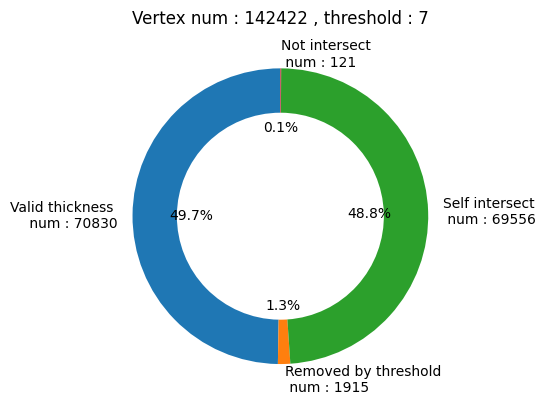

In [91]:
plot_data = [valid_thickness_num,removed_by_threshold,self_intersect_num,not_intersect_num]

labels = [f"Valid thickness \n num : {valid_thickness_num}",
          f"Removed by threshold \n num : {removed_by_threshold}", 
          f"Self intersect \n num : {self_intersect_num}",
          f"Not intersect \n num : {not_intersect_num}"]


# Create a pie chart
fig, ax = plt.subplots()
ax.pie(plot_data, labels=labels, startangle=90, wedgeprops=dict(width=0.3), autopct='%1.1f%%')

# Display
plt.title(f"Vertex num : {vertex_num} , threshold : {threshold}")
plt.show()

In [92]:
import pyvista as pv

print(thickness)
print(white)

white['new_thickness'] = thickness

print(white)
print(max(thickness))

write_vtk(white,'output.vtk')


[3.18507367        nan 3.35244491 ...        nan 3.63713319        nan]
{'vertices': array([[-33.0875 ,   5.35956, -30.0661 ],
       [-33.6076 ,   5.37578, -29.9285 ],
       [-33.2168 ,   4.80791, -29.9696 ],
       ...,
       [ -8.10695, -26.3459 ,  80.0389 ],
       [ -9.7135 , -25.4772 ,  79.6402 ],
       [ -8.80204, -25.6295 ,  79.7029 ]], dtype=float32), 'faces': array([[     3,      2,      1,      0],
       [     3,      0,      3,      2],
       [     3,      6,      5,      4],
       ...,
       [     3, 142334, 142420, 142336],
       [     3, 142336, 142420, 142421],
       [     3, 142336, 142421, 142331]], dtype=int64), 'thickness': array([3.32757632, 3.66757862, 3.19666151, ..., 3.7112704 , 3.66817025,
       3.49256995]), 'aparc': array([ 9.,  9.,  9., ..., 24., 24., 24.])}
{'vertices': array([[-33.0875 ,   5.35956, -30.0661 ],
       [-33.6076 ,   5.37578, -29.9285 ],
       [-33.2168 ,   4.80791, -29.9696 ],
       ...,
       [ -8.10695, -26.3459 ,  80.0389 ],


In [62]:
from vtk_revise import read_vtk



lh_white = read_vtk('./vtk_file/subj_1_lh_white.vtk')


new_thickness = lh_white['new_thickness']

print(new_thickness)

# num_zero = len(np.where(thickness==0)[0])
# num_nans = np.sum(np.isnan(thickness))
# print(num_zero)
# print(num_nans)

[3.18507367 0.         3.35244491 ... 0.         3.63713319 0.        ]


In [1]:
a = 0.99 * 1e-6
b = 1e-3 * (1-1e-6)

c = a / (a + b)

print(c)

0.0009890218573830483
